# ***Importing Libraries***

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import glob
import yaml
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

# ***Loading Dataset***

In [2]:
# Load data.yaml and handle potential errors
dataset_path = '/kaggle/input/liver-disease-dataset'
data_yaml_path = os.path.join(dataset_path, 'dataset', 'data.yaml')  # Corrected path
dataset_root = os.path.join(dataset_path, 'dataset')

# Extract information from data.yaml, handling missing keys
train_images_folder = os.path.join(dataset_root, "images", "train")
train_labels_folder = os.path.join(dataset_root, "labels", "train")
val_images_folder = os.path.join(dataset_root, "images", "val")
val_labels_folder = os.path.join(dataset_root, "labels", "val")
test_images_folder = os.path.join(dataset_root, "images", "test")
test_labels_folder = os.path.join(dataset_root, "labels", "test")
data_yaml = os.path.join(dataset_root, "data.yaml")

# Set hyperparameters
batch_size = 4  # Reduced from 8
img_size = 416  # Reduced from 640
gradient_accumulation_steps = 2

# CUDA check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
torch.backends.cudnn.benchmark = True

# ***Residue Block***

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential() if in_channels == out_channels and stride == 1 else \
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# ***Stable Loss***

In [4]:
# Update the StableLoss class to handle shape mismatches better
class StableLoss(nn.Module):
    def __init__(self, num_classes):
        super(StableLoss, self).__init__()
        self.num_classes = num_classes
        self.mse = nn.MSELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.entropy = nn.CrossEntropyLoss(reduction='mean')
    
    def forward(self, predictions, targets):
        # Verify shapes match
        if predictions.shape != targets.shape:
            raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
        
        # Extract target components
        obj_mask = targets[..., 4] > 0
        noobj_mask = targets[..., 4] == 0
        
        # No object loss
        noobj_loss = self.bce(
            predictions[..., 4][noobj_mask],
            targets[..., 4][noobj_mask]
        )
        
        if obj_mask.sum() > 0:
            # Box coordinates loss
            box_loss = self.mse(
                predictions[..., :4][obj_mask],
                targets[..., :4][obj_mask]
            )
            
            # Objectness loss
            obj_loss = self.bce(
                predictions[..., 4][obj_mask],
                targets[..., 4][obj_mask]
            )
            
            # Class prediction loss
            class_loss = self.entropy(
                predictions[..., 5:][obj_mask],
                targets[..., 5][obj_mask].long()
            )
            
            # Combine losses with weights
            total_loss = (
                box_loss * 1.0 +
                obj_loss * 1.0 +
                noobj_loss * 0.5 +
                class_loss * 1.0
            )
        else:
            total_loss = noobj_loss
        
        return total_loss

# ***YOLOv5 Class***

In [5]:
# First, modify the ImprovedYOLOv5 class to explicitly return the grid size
class ImprovedYOLOv5(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedYOLOv5, self).__init__()
        self.num_classes = num_classes

        # Backbone
        self.backbone = nn.Sequential(
            ResidualBlock(3, 32, stride=2), # 208x208
            ResidualBlock(32, 64),
            nn.MaxPool2d(2), # 104x104
            ResidualBlock(64, 128),
            ResidualBlock(128, 256),
            nn.MaxPool2d(2), # 52x52
            ResidualBlock(256, 512),
            ResidualBlock(512, 1024),
        )

        # Neck
        self.neck = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Detection head
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, (num_classes + 5), kernel_size=1) # 5 = (x,y,w,h,obj)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)

        # Reshape output to [batch_size, grid_size*grid_size, num_classes + 5]
        batch_size, channels, height, width = x.shape
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, height * width, channels)

        return x, (height, width)  # Return grid dimensions too

# ***Custom Dataset***

In [6]:
# Custom Dataset with Improved Error Handling
class ImprovedCustomDataset(Dataset):
    def __init__(self, images_folder, labels_folder, img_size=640, augment=False):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.img_size = img_size
        self.augment = augment

        self.image_paths = sorted(
            glob.glob(os.path.join(images_folder, '*.jpg')) +
            glob.glob(os.path.join(images_folder, '*.jpeg')) +
            glob.glob(os.path.join(images_folder, '*.png'))
        )
        print(f"Found {len(self.image_paths)} images in {images_folder}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self._load_image(image_path)
        
        image_filename = os.path.basename(image_path)
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = os.path.join(self.labels_folder, label_filename)
        
        label = self._load_label(label_path)
        
        if self.augment:
            image, label = self._augment_data(image, label)
        
        return image, label

    def _load_image(self, image_path):
        try:
            image = cv2.imread(image_path)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32) / 255.0
            image = np.transpose(image, (2, 0, 1))
            return torch.tensor(image).float()
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.zeros((3, self.img_size, self.img_size))

    def _load_label(self, label_path):
        try:
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                labels = np.loadtxt(label_path, delimiter=' ', ndmin=2)
                if labels.size > 0:
                    return torch.tensor(labels).float()
            return torch.zeros((0, 5))
        except Exception as e:
            print(f"Warning: Error loading label {label_path}: {str(e)}")
            return torch.zeros((0, 5))

    def _augment_data(self, image, label):
        if np.random.random() < 0.5:
            image = torch.flip(image, [2])
            if label.size(0) > 0:
                label[:, 1] = 1 - label[:, 1]
        return image, label

In [7]:
# Collate function
def collate_fn(batch):
    images = []
    labels = []
    for img, label in batch:
        if img is not None:
            images.append(img)
            labels.append(label)
    if len(images) > 0:
        images = torch.stack(images, dim=0)
        labels = labels  # Keep labels as a list of tensors
        return images, labels
    else:
        return None, None

In [8]:
# Prepare targets
def prepare_targets(target_list, device, num_classes, grid_size):
    batch_size = len(target_list)
    grid_height, grid_width = grid_size
    total_grid_cells = grid_height * grid_width
    
    target_tensor = torch.zeros((batch_size, total_grid_cells, num_classes + 5), device=device)

    for batch_index, targets in enumerate(target_list):
        if targets.numel() == 0:
            continue

        for target in targets:
            class_index = int(target[0])
            x_center, y_center, width, height = target[1:5]

            # Scale x,y to grid dimensions
            i = int(x_center * grid_width)
            j = int(y_center * grid_height)
            
            # Bound check to prevent index errors
            i = min(max(i, 0), grid_width - 1)
            j = min(max(j, 0), grid_height - 1)

            one_hot = torch.zeros(num_classes, device=device)
            one_hot[class_index] = 1.0

            x_cell = x_center * grid_width - i
            y_cell = y_center * grid_height - j

            index = j * grid_width + i
            target_tensor[batch_index, index, 0:4] = torch.tensor([x_cell, y_cell, width, height], device=device)
            target_tensor[batch_index, index, 4] = 1.0
            target_tensor[batch_index, index, 5:] = one_hot

    return target_tensor

In [9]:
import math

def calculate_metrics(predictions, targets, iou_threshold=0.5):
    """
    Calculate object detection metrics.
    
    Args:
        predictions: Model predictions in format [batch_size, grid_cells, 5+num_classes]
        targets: Ground truth targets in same format
        iou_threshold: IoU threshold to consider detection as correct
        
    Returns:
        Dictionary of metrics including accuracy, precision, recall, F1 score
    """
    batch_size = predictions.size(0)
    metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1_score': 0.0
    }
    
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    # Process each image in batch
    for i in range(batch_size):
        # Apply sigmoid to objectness and softmax to class predictions
        pred_objectness = torch.sigmoid(predictions[i, :, 4])
        pred_classes = torch.softmax(predictions[i, :, 5:], dim=1)
        
        # Get objectness mask from targets (ground truth)
        target_obj_mask = targets[i, :, 4] > 0.5
        
        # If there are no objects in this image, skip
        if not target_obj_mask.any():
            continue
            
        # Count how many grid cells have objects (true positives + false negatives)
        num_gt_objects = target_obj_mask.sum().item()
        
        # Count predictions with objectness > 0.5 (true positives + false positives)
        pred_obj_mask = pred_objectness > 0.5
        num_pred_objects = pred_obj_mask.sum().item()
        
        # Count correct object detections (objectness and position)
        # This is a simplified accuracy measure
        correct_obj = (pred_obj_mask & target_obj_mask).sum().item()
        
        # Calculate metrics for this image
        tp = correct_obj
        fp = num_pred_objects - tp
        fn = num_gt_objects - tp
        
        # Accumulate for batch metrics
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Image accuracy = percentage of grid cells correctly classified
        batch_accuracy = correct_obj / max(1, num_gt_objects)
        metrics['accuracy'] += batch_accuracy
    
    # Calculate batch-level metrics
    metrics['accuracy'] /= batch_size
    
    # Precision = TP / (TP + FP)
    metrics['precision'] = total_tp / max(1, total_tp + total_fp)
    
    # Recall = TP / (TP + FN)
    metrics['recall'] = total_tp / max(1, total_tp + total_fn)
    
    # F1 score = 2 * Precision * Recall / (Precision + Recall)
    if metrics['precision'] + metrics['recall'] > 0:
        metrics['f1_score'] = 2 * metrics['precision'] * metrics['recall'] / (metrics['precision'] + metrics['recall'])
    
    return metrics

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
        optimizer.zero_grad()
        
        # Track batches for gradient accumulation
        valid_batches = 0
        
        for batch_idx, (batch_images, batch_targets) in enumerate(train_loader):
            if batch_images is None:
                continue
            
            try:
                batch_images = batch_images.to(device)
                
                # Get both outputs and grid size
                outputs, grid_size = model(batch_images)
                
                # Use the actual grid size from the model
                prepared_targets = prepare_targets(batch_targets, device, model.num_classes, grid_size)
                
                loss = criterion(outputs, prepared_targets)
                
                # Calculate metrics
                batch_metrics = calculate_metrics(outputs, prepared_targets)
                for key in train_metrics:
                    train_metrics[key] += batch_metrics.get(key, 0.0)
                
                # Normalize loss by gradient accumulation steps
                loss = loss / gradient_accumulation_steps
                loss.backward()
                
                if (batch_idx + 1) % gradient_accumulation_steps == 0:
                    # Gradient clipping to prevent explosion
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                
                train_loss += loss.item() * gradient_accumulation_steps
                valid_batches += 1
                
                # Print progress
                if batch_idx % 20 == 0:
                    print(f'Train Epoch: {epoch+1} [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')
                
                # Clean up GPU memory
                del outputs, loss, batch_images, prepared_targets
                torch.cuda.empty_cache()
            
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"WARNING: out of memory on batch {batch_idx}. Skipping...")
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    continue
                else:
                    print(f"Error in batch {batch_idx}: {str(e)}")
                    raise e
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
        valid_val_batches = 0
        
        with torch.no_grad():
            for val_images, val_targets in val_loader:
                if val_images is None:
                    continue
                
                try:
                    val_images = val_images.to(device)
                    
                    # Get both outputs and grid size
                    val_outputs, val_grid_size = model(val_images)
                    
                    # Use the actual grid size from the model
                    prepared_val_targets = prepare_targets(val_targets, device, model.num_classes, val_grid_size)
                    
                    val_batch_loss = criterion(val_outputs, prepared_val_targets)
                    val_loss += val_batch_loss.item()
                    
                    # Calculate validation metrics
                    batch_val_metrics = calculate_metrics(val_outputs, prepared_val_targets)
                    for key in val_metrics:
                        val_metrics[key] += batch_val_metrics.get(key, 0.0)
                    
                    valid_val_batches += 1
                    
                    # Clean up GPU memory
                    del val_outputs, val_batch_loss, val_images, prepared_val_targets
                    torch.cuda.empty_cache()
                
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("WARNING: out of memory during validation. Skipping batch...")
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        continue
                    else:
                        print(f"Error in validation: {str(e)}")
                        raise e

        # Calculate epoch metrics
        avg_train_loss = train_loss / max(1, valid_batches)
        avg_val_loss = val_loss / max(1, valid_val_batches)
        
        # Average the metrics
        for key in train_metrics:
            train_metrics[key] /= max(1, valid_batches)
            val_metrics[key] /= max(1, valid_val_batches)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Acc: {train_metrics["accuracy"]:.4f}, P: {train_metrics["precision"]:.4f}, R: {train_metrics["recall"]:.4f}, F1: {train_metrics["f1_score"]:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Acc: {val_metrics["accuracy"]:.4f}, P: {val_metrics["precision"]:.4f}, R: {val_metrics["recall"]:.4f}, F1: {val_metrics["f1_score"]:.4f}')
        
        # Update learning rate based on validation loss
        scheduler.step(avg_val_loss)
        
        # Clean up memory
        gc.collect()
        torch.cuda.empty_cache()
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Saving best model with val_loss: {best_val_loss:.4f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
                'metrics': val_metrics
            }, 'best_liver_disease_model.pth')
        
    return model

In [11]:
def predict_disease(model, image_path, device, img_size=416, confidence_threshold=0.5):
    """
    Predict liver disease from image.
    
    Args:
        model: Trained model
        image_path: Path to the liver image
        device: Device to run inference on
        img_size: Input image size
        confidence_threshold: Threshold for detection confidence
        
    Returns:
        List of detections with disease class, confidence, and bounding box
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return []
        
    original_h, original_w = image.shape[:2]
    image = cv2.resize(image, (img_size, img_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image_tensor = torch.tensor(image).float().unsqueeze(0).to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        predictions, grid_size = model(image_tensor)
    
    # Convert predictions to boxes
    raw_detections = extract_boxes(predictions[0], confidence_threshold)
    
    # Convert to output format with class names
    class_names = ['healthy', 'fatty_liver', 'cirrhosis', 'hepatitis']
    
    detections = []
    for det in raw_detections:
        x1, y1, x2, y2 = det['box']
        class_id = det['class_id']
        confidence = det['confidence'] * det['class_prob']  # Combined confidence
        
        # Convert normalized coordinates to image coordinates
        x1_img = x1 * original_w
        y1_img = y1 * original_h
        x2_img = x2 * original_w
        y2_img = y2 * original_h
        
        detections.append({
            'disease': class_names[class_id],
            'confidence': confidence,
            'bbox': [x1_img, y1_img, x2_img, y2_img]
        })
    
    return detections

In [12]:
def extract_boxes(grid_predictions, confidence_threshold=0.5):
    """
    Convert grid cell predictions to bounding boxes.
    
    Args:
        grid_predictions: Tensor of shape [grid_cells, 5+num_classes]
        confidence_threshold: Minimum confidence to keep a detection
        
    Returns:
        List of dictionaries with format:
        {
            'box': [x1, y1, x2, y2],  # normalized 0-1 coordinates
            'confidence': float,       # objectness score
            'class_id': int,           # predicted class ID
            'class_prob': float        # class probability
        }
    """
    import math
    
    # Get dimensions
    grid_cells = grid_predictions.size(0)
    grid_size = int(math.sqrt(grid_cells))
    num_classes = grid_predictions.size(1) - 5
    
    # Apply sigmoid to objectness
    objectness = torch.sigmoid(grid_predictions[:, 4])
    
    # Filter by confidence threshold
    confident_mask = objectness > confidence_threshold
    
    # Return empty list if no confident detections
    if not confident_mask.any():
        return []
    
    # Get grid positions for confident detections
    confident_indices = confident_mask.nonzero(as_tuple=True)[0]
    grid_y = torch.div(confident_indices, grid_size, rounding_mode='floor')
    grid_x = confident_indices % grid_size
    
    # Get predictions for confident cells
    confident_preds = grid_predictions[confident_indices]
    
    # Apply sigmoid and softmax to get proper probabilities
    x_center = (torch.sigmoid(confident_preds[:, 0]) + grid_x) / grid_size
    y_center = (torch.sigmoid(confident_preds[:, 1]) + grid_y) / grid_size
    w = torch.exp(confident_preds[:, 2])  # Apply exponential to width
    h = torch.exp(confident_preds[:, 3])  # Apply exponential to height
    
    # Convert to corner coordinates (normalized 0-1)
    x1 = torch.clamp(x_center - w/2, 0, 1)
    y1 = torch.clamp(y_center - h/2, 0, 1)
    x2 = torch.clamp(x_center + w/2, 0, 1)
    y2 = torch.clamp(y_center + h/2, 0, 1)
    
    # Get class probabilities and IDs
    class_probs = torch.softmax(confident_preds[:, 5:], dim=1)
    class_ids = torch.argmax(class_probs, dim=1)
    max_class_probs = torch.max(class_probs, dim=1)[0]
    
    # Create list of detections
    detections = []
    for i in range(len(confident_indices)):
        if w[i] * h[i] > 0:  # Ensure valid box size
            detections.append({
                'box': [x1[i].item(), y1[i].item(), x2[i].item(), y2[i].item()],
                'confidence': objectness[confident_indices[i]].item(),
                'class_id': class_ids[i].item(),
                'class_prob': max_class_probs[i].item()
            })
    
    return detections

In [13]:
def visualize_prediction(image_path, detections):
    """
    Visualize disease detection results on the image.
    
    Args:
        image_path: Path to the original image
        detections: List of detection dictionaries
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Colors for different classes
    colors = {
        'healthy': (0, 255, 0),       # Green
        'fatty_liver': (255, 255, 0),  # Yellow
        'cirrhosis': (255, 0, 0),      # Red
        'hepatitis': (0, 0, 255)       # Blue
    }
    
    # Draw detections
    for detection in detections:
        x1, y1, x2, y2 = [int(coord) for coord in detection['bbox']]
        disease = detection['disease']
        confidence = detection['confidence']
        
        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), colors[disease], 2)
        
        # Add label
        label = f"{disease}: {confidence:.2f}"
        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[disease], 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Liver Disease Detection')
    plt.show()

# ***Training***

In [14]:
# Instantiate Datasets
train_dataset = ImprovedCustomDataset(train_images_folder, train_labels_folder, img_size=img_size, augment=True)
val_dataset = ImprovedCustomDataset(val_images_folder, val_labels_folder, img_size=img_size, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Model and Optimizer
model = ImprovedYOLOv5(num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = StableLoss(num_classes=4).to(device)
num_epochs = 10

# Train model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)


Found 2782 images in /kaggle/input/liver-disease-dataset/dataset/images/train
Found 794 images in /kaggle/input/liver-disease-dataset/dataset/images/val


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/696] Loss: 1.3266
Train Epoch: 1 [20/696] Loss: 0.5114
Train Epoch: 1 [40/696] Loss: 0.5297
Train Epoch: 1 [60/696] Loss: 0.5396
Train Epoch: 1 [80/696] Loss: 0.4774
Train Epoch: 1 [100/696] Loss: 0.5178
Train Epoch: 1 [120/696] Loss: 0.3739
Train Epoch: 1 [140/696] Loss: 0.6399
Train Epoch: 1 [160/696] Loss: 0.6285
Train Epoch: 1 [180/696] Loss: 0.8160
Train Epoch: 1 [200/696] Loss: 0.5576
Train Epoch: 1 [220/696] Loss: 0.6518
Train Epoch: 1 [240/696] Loss: 0.5482
Train Epoch: 1 [260/696] Loss: 0.3810
Train Epoch: 1 [280/696] Loss: 0.4715
Train Epoch: 1 [300/696] Loss: 0.9851
Train Epoch: 1 [320/696] Loss: 0.3809
Train Epoch: 1 [340/696] Loss: 0.3551
Train Epoch: 1 [360/696] Loss: 0.7423
Train Epoch: 1 [380/696] Loss: 0.3517
Train Epoch: 1 [400/696] Loss: 0.3234
Train Epoch: 1 [420/696] Loss: 0.4507
Train Epoch: 1 [440/696] Loss: 0.4400
Train Epoch: 1 [460/696] Loss: 0.2978
Train Epoch: 1 [480/696] Loss: 0.2542
Train Epoch: 1 [500/696] Loss: 0.3320
Train Epoch: 1 [52

<ipython-input-15-4e727475df33>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_liver_disease_model.pth')


Detected healthy with 0.54 confidence
Location: [0.0, 0.0, 299.0, 203.14941197633743]
Detected healthy with 0.94 confidence
Location: [56.90996170043945, 0.0, 299.0, 178.59877514839172]
Detected healthy with 0.85 confidence
Location: [63.296292781829834, 0.0, 299.0, 179.89130038022995]
Detected healthy with 0.71 confidence
Location: [75.43435668945312, 0.0, 299.0, 199.6744126677513]
Detected healthy with 0.88 confidence
Location: [83.47843492031097, 0.0, 299.0, 192.90222203731537]
Detected healthy with 0.79 confidence
Location: [89.99997991323471, 0.0, 299.0, 191.07778769731522]
Detected healthy with 0.72 confidence
Location: [0.0, 0.0, 299.0, 199.79365825653076]
Detected healthy with 0.97 confidence
Location: [0.0, 0.0, 299.0, 189.81785851716995]
Detected healthy with 0.99 confidence
Location: [0.0, 0.0, 299.0, 184.96849632263184]
Detected healthy with 0.97 confidence
Location: [0.0, 0.0, 299.0, 185.83531248569489]
Detected healthy with 0.63 confidence
Location: [0.0, 0.0, 299.0, 197.

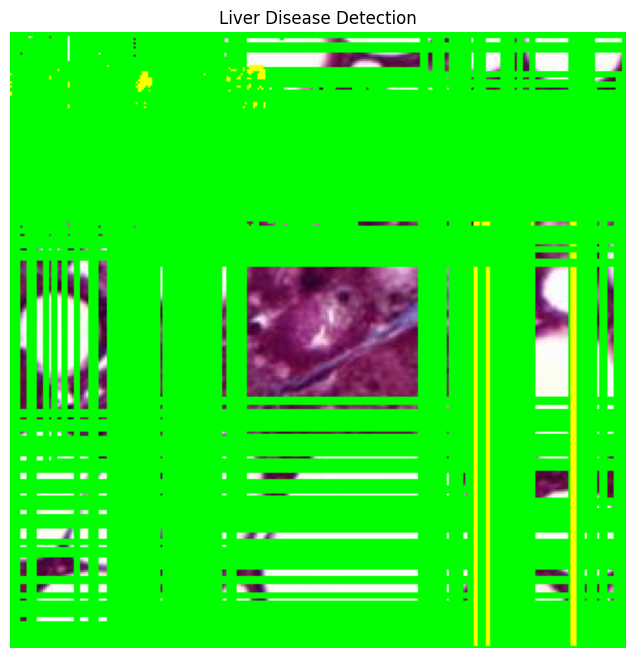

In [15]:
import matplotlib.pyplot as plt
checkpoint = torch.load('best_liver_disease_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Predict on a new image
test_image_path = '/kaggle/input/test-image/208_6_2_41_jpg.rf.b376c6347c660d4b97a23c2086d79f2a.jpg'
detections = predict_disease(model, test_image_path, device)

# Display results
for detection in detections:
    print(f"Detected {detection['disease']} with {detection['confidence']:.2f} confidence")
    print(f"Location: {detection['bbox']}")

# Visualize
visualize_prediction(test_image_path, detections)